# **Custom GPT**

In [5]:
# !pip install numpy==1.26.0
# !pip install torch==2.2.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install torchtext==0.17.2
# !pip install torchdata==0.7.1
# !pip install portalocker==2.8.2
!pip install pandas==2.2.1
# !pip install matplotlib==3.9.0 scikit-learn==1.5.0
# !pip install transformers==4.31.0

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import Iterable, List
import math

import torch
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam

from torchtext.datasets import multi30k, Multi30k
from torchtext.vocab import Vocab
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import IMDB,PennTreebank
from transformers import GPT2Tokenizer, GPT2LMHeadModel


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

## Dataset

In [2]:
train_iter, val_iter = IMDB()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_itr=iter(train_iter)
next(data_itr)

(1,
 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far betwee

## Preprocessing Data

In [3]:
UNK_IDX, PAD_IDX, EOS_IDX = 0, 1, 2
special_symbols = ['<unk>', '<pad>', '<|endoftext|>' ]

tokenizer = get_tokenizer("basic_english")

In [4]:
def yield_tokens(data_iter):
    for _,data_sample in data_iter:
        yield  tokenizer(data_sample)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=special_symbols, special_first=True)
vocab.set_default_index(UNK_IDX)

In [5]:
text_to_index=lambda text: [vocab(token) for token in tokenizer(text)]
index_to_en = lambda seq_en: " ".join([vocab.get_itos()[index] for index in seq_en])

index_to_en(torch.tensor([0,1,2]))

'<unk> <pad> <|endoftext|>'

### Collate Function

In [6]:
def get_sample(block_size, text):
    # Determine the length of the input text
    sample_leg = len(text)
    # Calculate the stopping point for randomly selecting a sample
    # This ensures the selected sample doesn't exceed the text length
    random_sample_stop = sample_leg - block_size


    # Check if a random sample can be taken (if the text is longer than block_size)
    if random_sample_stop >= 1:
        # Randomly select a starting point for the sample
        random_start = torch.randint(low=0, high=random_sample_stop, size=(1,)).item()
        # Define the endpoint of the sample
        stop = random_start + block_size

        # Create the input and target sequences
        src_sequence = text[random_start:stop]
        tgt_sequence= text[random_start + 1:stop + 1]

    # Handle the case where the text length is exactly equal or less the block size
    elif random_sample_stop <= 0:
        # Start from the beginning and use the entire text
        random_start = 0
        stop = sample_leg
        src_sequence= text[random_start:stop]
        tgt_sequence = text[random_start + 1:stop]
        # Append an empty string to maintain sequence alignment
        tgt_sequence.append( '<|endoftext|>')

    return src_sequence, tgt_sequence

In [7]:
# Initialize empty lists to store source and target sequences
src_batch, tgt_batch = [], []
block_size=10

# Define the batch size
BATCH_SIZE = 2

# Loop to create batches of source and target sequences
for i in range(BATCH_SIZE):
    # Retrieve the next data point from the training iterator
    _,text = next(iter(train_iter))

    # Generate source and target sequences using the get_sample function
    src_sequence_text, tgt_sequence_text = get_sample(block_size, tokenizer(text))

    # Convert source and target sequences to tokenized vocabulary indices
    src_sequence_indices = vocab(src_sequence_text)
    tgt_sequence_indices = vocab(tgt_sequence_text)

    # Convert the sequences to PyTorch tensors with dtype int64
    src_sequence = torch.tensor(src_sequence_indices, dtype=torch.int64)
    tgt_sequence = torch.tensor(tgt_sequence_indices, dtype=torch.int64)

    # Append the source and target sequences to their respective batches
    src_batch.append(src_sequence)
    tgt_batch.append(tgt_sequence)

    # Print the output for every 2nd sample (adjust as needed)
    print(f"Sample {i}:")
    print("Source Sequence (Text):", src_sequence_text)
    print("Source Sequence (Indices):", src_sequence_indices)
    print("Source Sequence (Shape):", src_sequence.shape)
    print("Target Sequence (Text):", tgt_sequence_text)
    print("Target Sequence (Indices):", tgt_sequence_indices)
    print("Target Sequence (Shape):", tgt_sequence.shape)

Sample 0:
Source Sequence (Text): ['in', 'the', 'film', 'is', 'shown', 'for', 'artistic', 'purposes', 'rather', 'than']
Source Sequence (Indices): [14, 4, 25, 11, 693, 20, 1668, 4919, 253, 82]
Source Sequence (Shape): torch.Size([10])
Target Sequence (Text): ['the', 'film', 'is', 'shown', 'for', 'artistic', 'purposes', 'rather', 'than', 'just']
Target Sequence (Indices): [4, 25, 11, 693, 20, 1668, 4919, 253, 82, 45]
Target Sequence (Shape): torch.Size([10])
Sample 1:
Source Sequence (Text): ['making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'swede']
Source Sequence (Indices): [233, 55, 398, 9, 814, 28, 54, 4, 753, 22750]
Source Sequence (Shape): torch.Size([10])
Target Sequence (Text): ['some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'swede', 'thought']
Target Sequence (Indices): [55, 398, 9, 814, 28, 54, 4, 753, 22750, 207]
Target Sequence (Shape): torch.Size([10])


In [8]:
BLOCK_SIZE=30
def collate_batch(batch):
    src_batch, tgt_batch = [], []
    for _,_textt in batch:
      src_sequence,tgt_sequence=get_sample(BLOCK_SIZE,tokenizer(_textt))
      src_sequence=vocab(src_sequence)
      tgt_sequence=vocab(tgt_sequence)
      src_sequence= torch.tensor(src_sequence, dtype=torch.int64)
      tgt_sequence = torch.tensor(tgt_sequence, dtype=torch.int64)
      src_batch.append(src_sequence)
      tgt_batch.append(tgt_sequence)


    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=False)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=False)

    return src_batch.to(DEVICE), tgt_batch.to(DEVICE)

In [9]:
BATCH_SIZE=1
dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_dataloader= DataLoader(val_iter , batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

In [11]:
dataset=iter(dataloader)
for sample in range(2):
  src,trt=next(dataset)
  print("sample",sample)
  print("sorce:",index_to_en(src))
  print("\n")
  print("target:",index_to_en(trt))
  print("\n")
  print(trt.shape)
  print(src.shape)
  print("\n")


sample 0
sorce: right from the start . this is not a movie that i liked . i didn ' t hate it in the way of some movies that insult your intelligence


target: from the start . this is not a movie that i liked . i didn ' t hate it in the way of some movies that insult your intelligence ,


torch.Size([30, 1])
torch.Size([30, 1])


sample 1
sorce: of the worst movies i have ever seen . the dialogue is ghastly , the horror effects are laughable . the only thing that kept me watching was the ever-splendid


target: the worst movies i have ever seen . the dialogue is ghastly , the horror effects are laughable . the only thing that kept me watching was the ever-splendid and


torch.Size([30, 1])
torch.Size([30, 1])




## Masking

In [20]:
def generate_square_subsequent_mask(sz,device=DEVICE):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src,device=DEVICE):
    src_seq_len = src.shape[0]
    src_mask = generate_square_subsequent_mask(src_seq_len)
    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    return src_mask,src_padding_mask

## Positional Encoding

In [13]:
# add positional information to the input tokens
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

## Token Embedding

In [14]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

## Custom GPT model architecture

In [15]:
class CustomGPTModel(nn.Module):
    def __init__(self, embed_size,vocab_size, num_heads, num_layers, max_seq_len=500,dropout=0.1):

        super().__init__()

        self.init_weights()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, dropout=dropout)

        print( embed_size )


        # Remaining layers are part of the TransformerDecoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.embed_size = embed_size
        self.lm_head = nn.Linear(embed_size, vocab_size)

    def init_weights(self):
      for p in self.parameters():
          if p.dim() > 1:
              nn.init.xavier_uniform_(p)

    def create_mask(src,device=DEVICE):
        src_seq_len = src.shape[0]
        src_mask = nn.Transformer.generate_square_subsequent_mask(src_seq_len)
        src_padding_mask = (src == PAD_IDX).transpose(0, 1)
        return src_mask,src_padding_mask

    def decoder(self, x,src_mask):
        seq_length = x.size(0)

        # Add positional embeddings to the input embeddings
        x = self.embed(x)* math.sqrt(self.embed_size)
        x = self.positional_encoding(x)

        if src_mask is None:
            """Generate a square causal mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
            """
            src_mask, src_padding_mask = create_mask(x)

        output = self.transformer_encoder(x, src_mask)
        logits = self.lm_head(x)
        return logits

    def forward(self,x,src_mask=None,key_padding_mask=None):

        seq_length = x.size(0)

        # Add positional embeddings to the input embeddings
        x = self.embed(x)* math.sqrt(self.embed_size) #src = self.embedding(src) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)


        if src_mask is None:
            """Generate a square causal mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
            """
            src_mask, src_padding_mask = create_mask(x)

        output = self.transformer_encoder(x, src_mask,key_padding_mask)
        x = self.lm_head(x)

        return x

### Model configuration and initialization

In [16]:
ntokens = len(vocab)  # size of vocabulary
emsize = 200  # embedding dimension
nlayers = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability

model = CustomGPTModel(embed_size=emsize, num_heads=nhead, num_layers=nlayers, vocab_size=ntokens,dropout=dropout).to(DEVICE)

200


## Prompting

In [17]:
def encode_prompt(prompt, block_size=BLOCK_SIZE):
    # Handle None prompt
    while prompt is None:
        prompt = input("Sorry, prompt cannot be empty. Please enter a valid prompt: ")

    tokens = tokenizer(prompt)
    number_of_tokens = len(tokens)

    # Handle long prompts
    if number_of_tokens > block_size:
        tokens = tokens[-block_size:]  # Keep last block_size characters

    prompt_indices = vocab(tokens)
    prompt_encoded = torch.tensor(prompt_indices, dtype=torch.int64).reshape(-1, 1)
    return prompt_encoded


prompt_encoded=encode_prompt("This is a prompt to get model generate next words.").to(DEVICE)
prompt_encoded

tensor([[   15],
        [   11],
        [    6],
        [33700],
        [   10],
        [   86],
        [ 2076],
        [ 5673],
        [  388],
        [  665],
        [    3]], device='cuda:0')

In [21]:
logits = model.decoder(prompt_encoded,src_mask=None).to(DEVICE).transpose(0, 1)
logit_preiction =logits[:,-1]
_, next_word_index = torch.max(logit_preiction, dim=1)
index_to_en(next_word_index)

'distortion'

## Autoregressive text generation

In [22]:
#auto-regressive Language Model text generation
def generate(model, prompt=None, max_new_tokens=500, block_size=BLOCK_SIZE, vocab=vocab, tokenizer=tokenizer):
    # Move model to the specified device (e.g., GPU or CPU)
    model.to(DEVICE)

    # Encode the input prompt using the provided encode_prompt function
    prompt_encoded = encode_prompt(prompt).to(DEVICE)
    tokens = []

    # Generate new tokens up to max_new_tokens
    for _ in range(max_new_tokens):
        # Decode the encoded prompt using the model's decoder
        logits = model(prompt_encoded,src_mask=None,key_padding_mask=None)

        # Transpose the logits to bring the sequence length to the first dimension
        logits = logits.transpose(0, 1)

        # Select the logits of the last token in the sequence
        logit_prediction = logits[:, -1]

        # Choose the most probable next token from the logits(greedy decoding)
        next_token_encoded = torch.argmax(logit_prediction, dim=-1).reshape(-1, 1)

        # If the next token is the end-of-sequence (EOS) token, stop generation
        if next_token_encoded.item() == EOS_IDX:
            break

        # Append the next token to the prompt_encoded and keep only the last 'block_size' tokens
        prompt_encoded = torch.cat((prompt_encoded, next_token_encoded), dim=0)[-block_size:]

        # Convert the next token index to a token string using the vocabulary
        # Move the tensor back to CPU for vocab lookup if needed
        token_id = next_token_encoded.to('cpu').item()
        tokens.append(vocab.get_itos()[token_id])

    # Join the generated tokens into a single string and return
    return (prompt + ' '.join(tokens))


generate(model,prompt="this is the beginning of ",max_new_tokens=30,vocab=vocab,tokenizer=tokenizer)

'this is the beginning of distaste under-acting centre oralist bricked idolize 2003 herrmann eyeing spradling symmetric pentecost restraining asking qualifiers shamus bleibtreau regretful callous bush pulsating dave propositions slopped freaky jokes/set-ups dumping visors accidentee *want*'

## Training

In [23]:
from torch.nn import CrossEntropyLoss
loss_fn = CrossEntropyLoss(ignore_index=PAD_IDX)

def evaluate(model: nn.Module, eval_data) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for src,tgt in eval_data:
            tgt = tgt.to(DEVICE)
            #seq_len = src.size(0)
            logits = model(src,src_mask=None,key_padding_mask=None)
            total_loss +=  loss_fn(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1)).item()
    return total_loss / (len(list(eval_data)) - 1)


evaluate(model,val_dataloader)

35.535376511801196

In [24]:
optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.01, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10000, gamma=0.9)

def train(model: nn.Module,train_data) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 10000
    start_time = time.time()

    num_batches = len(list(train_data)) // block_size
    for batch,srctgt in enumerate(train_data):
        src= srctgt[0]
        tgt= srctgt[1]
        logits = model(src,src_mask=None)
        logits_flat = logits.reshape(-1, logits.shape[-1])
        loss = loss_fn(logits_flat, tgt.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        total_loss += loss.item()

        if (batch % log_interval == 0 and batch > 0) or batch==42060:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            #cur_loss = total_loss / log_interval
            cur_loss = total_loss / batch
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch//block_size:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.4f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            start_time = time.time()

    return total_loss

In [25]:
best_val_loss = float('inf')
epochs = 5
Train_losses= []
Val_losses = []
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_loss = train(model,dataloader)
    val_loss = evaluate(model, val_dataloader)
    val_ppl = math.exp(val_loss)
    Train_losses.append(train_loss)
    Val_losses.append(val_loss)

    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
        f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'model_best_val_loss.pt')

| epoch   1 |  1000/ 1250 batches | lr 0.0100 | ms/batch 16.15 | loss  8.35 | ppl  4214.38
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 276.83s | valid loss  8.26 | valid ppl  3881.88
-----------------------------------------------------------------------------------------
| epoch   2 |  1000/ 1250 batches | lr 0.0100 | ms/batch 16.00 | loss  8.22 | ppl  3721.72
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 275.78s | valid loss  8.27 | valid ppl  3902.57
-----------------------------------------------------------------------------------------
| epoch   3 |  1000/ 1250 batches | lr 0.0100 | ms/batch 16.06 | loss  8.22 | ppl  3702.00
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 275.60s | valid loss  8.13 | valid ppl  3410.40
----------------------------------------------------

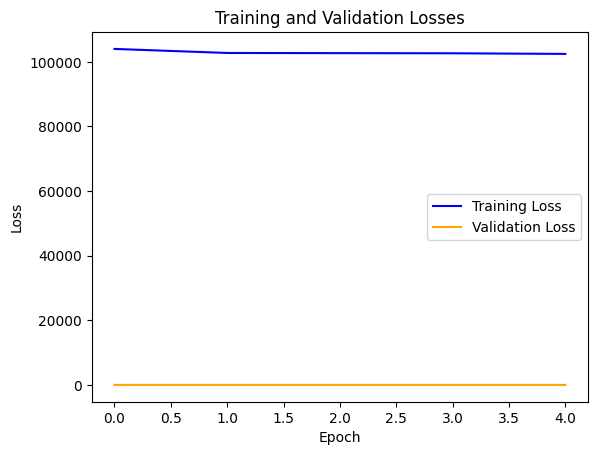

In [26]:
# Calculate the number of epochs (assuming the lengths of train_losses and val_losses are equal)
num_epochs = len(Train_losses)

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot the training losses
ax.plot(range(num_epochs), Train_losses, label='Training Loss', color='blue')

# Plot the validation losses
ax.plot(range(num_epochs), Val_losses, label='Validation Loss', color='orange')

# Set the x-axis label
ax.set_xlabel('Epoch')

# Set the y-axis label
ax.set_ylabel('Loss')

# Set the title of the plot
ax.set_title('Training and Validation Losses')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

## Loading the saved model

In [ ]:
#!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kyn1_OsXrzjef0xihlsXmg.pt'
#model.load_state_dict(torch.load('kyn1_OsXrzjef0xihlsXmg.pt',map_location=torch.device('cpu')))

## Loading GPT2 model from HuggingFace

In [27]:
# Load the tokenizer and model
tokenizer1 = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Define the input prompt
#input_text = "Once upon a time in a faraway land,"
input_text = "the movie was"

# Tokenize the input text and prepare the input for the model
input_ids = tokenizer1.encode(input_text, return_tensors="pt")

# Generate text using the model
# Set the desired length of the generated text (max_length),
# and other generation parameters like temperature, top_k, and top_p
max_length = 15
temperature = 0.7
top_k = 50
top_p = 0.95

generated_ids = model.generate(
    input_ids,
    max_length=max_length,
    temperature=temperature,
    top_k=top_k,
    top_p=top_p,
    pad_token_id=tokenizer1.eos_token_id,
)

# Decode the generated text
generated_text = tokenizer1.decode(generated_ids[0], skip_special_tokens=True)

# Print the input prompt and the generated text
print(f"Input: {input_text}")
print(f"Generated Text: {generated_text}")

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Input: the movie was
Generated Text: the movie was a bit of a disappointment, but it was a great movie
